# Forecasting Brazil’s Oil Production using an ARIMA model and ANP data
<b>Luís Eduardo Anunciado Silva</b> - BS Student in Information Technology, Federal University of Rio Grande do Norte<br>

<b>Date</b>: December 5, 2018

## Introduction
My project aims to predict the yearly oil production of a given petroleum reservoir over a given time period, using an <b>ARIMA model</b> for <b>time series forecasting</b> and the [ANP public data base](http://www.anp.gov.br/dados-estatisticos).

<p>I also aim to predict the top-10 petroleum reservoir in the Brazil that which will produce the largest amount of oil in the next 10 years.</p>


### OBJECTIVE 1: Predicting the Oil Production of a Petroleum Reservoir across a Specified Time Period
<p> Using the ANP public data base, we will do the following steps below:</p>

<b>Pre-Processing:</b><br>
<ol>
<li>Build a dataframe with the columns: dt (in DateTime format), well, latitude, longitude.</li>
<li>Dropping irrelevant columns and removing rows with NaN values</li>
</ol>
<b>Processing:</b><br>
ARIMA models need the data to be stationary i.e. the data must not exhibit trend and/or seasonality. To identify and remove trend and seasonality, we used the following methods:
<ol>
<li>Plotting the time series to visually check for trend and seasonality</li>
<li>Checking if the histogram of the data fits a Gaussian Curve, and then splitting data into two parts, calculating means and variances and seeing if they vary</li>
<li>Calculating the Augmented Dickey-Fuller Test statistic and using the p-value to determine stationarity</li>
</ol>
If the data was not stationary, we performed <b>differencing</b> to make it stationary.
<br><br>
<b>Fitting the ARIMA model:</b><br>
We performed a grid-search to estimate the best p, q values for the model, for the given data.<br>
We then fit the ARIMA model using the calculated p, q values.
<br><br>
<b>Evaluation:</b><br>
We calculated the <b>Mean Squared Error (MSE)</b> to estimate the performance of the model.

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
import plotly.plotly as py
import seaborn as sns
import folium
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from os import walk
from unicodedata import normalize
init_notebook_mode(connected=True)

# hide warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
#read file with the weels
dfs = pd.read_excel('../data/table_of_wells_april_2018.xlsx', sheet_name='Plan1')
dfs = dfs.drop({'CADASTRO', 'OPERADOR', 'POCO_OPERADOR', 'ESTADO', 'BACIA', 'BLOCO', 'SIG_CAMPO', 'CAMPO', 'TERRA_MAR', 
                'POCO_POS_ANP', 'INICIO', 'TERMINO', 'CONCLUSAO', 'TITULARIDADE', 'LATITUDE_BASE_4C', 
                'LONGITUDE_BASE_4C', 'DATUM_HORIZONTAL', 'TIPO_DE_COORDENADA_DE_BASE', 'DIRECAO', 'PROFUNDIDADE_VERTICAL_M',
                'PROFUNDIDADE_SONDADOR_M','PROFUNDIDADE_MEDIDA_M', 'REFERENCIA_DE_PROFUNDIDADE', 'MESA_ROTATIVA', 
                'COTA_ALTIMETRICA_M','LAMINA_D_AGUA_M', 'DATUM_VERTICAL', 'UNIDADE_ESTRATIGRAFICA', 'GEOLOGIA_GRUPO_FINAL',
                'GEOLOGIA_FORMACAO_FINAL', 'GEOLOGIA_MEMBRO_FINAL', 'CDPE', 'AGP', 'PC', 'PAG', 'PERFIS_CONVENCIONAIS',
                'DURANTE_PERFURACAO', 'PERFIS_DIGITAIS', 'PERFIS_PROCESSADOS', 'PERFIS_ESPECIAIS', 'AMOSTRA_LATERAL', 
                'SISMICA', 'TABELA_TEMPO_PROFUNDIDADE', 'DADOS_DIRECIONAIS', 'TESTE_A_CABO', 'CANHONEIO', 'TESTEMUNHO', 
                'GEOQUIMICA', 'SIG_SONDA', 'NOM_SONDA', 'DHA_ATUALIZACAO'}, 1)

In [3]:
def get_produtors(dfs):
    '''
    Filters producting wells in a field
    '''
    productor = dfs[(dfs['TIPO']==u'Explotatório') & 
                    (dfs['SITUACAO']=='PRODUZINDO') & 
                    (dfs['CATEGORIA']=='Desenvolvimento') & 
                    (dfs['RECLASSIFICACAO']==u'PRODUTOR COMERCIAL DE PETRÓLEO')]
    productor.reset_index(inplace=True)
    return productor

In [4]:
def get_injections(dfs):
    '''
    Filters the injection wells in a field
    '''
    injector = dfs[(dfs['TIPO']==u'Explotatório') & 
                   (dfs['SITUACAO']=='INJETANDO') &
                   (dfs['CATEGORIA']==u'Injeção') & 
                   (dfs['RECLASSIFICACAO']==u'INJEÇÃO DE ÁGUA')]
    injector.reset_index(inplace=True)
    return injector

In [5]:
produtor = get_produtors(dfs)
injetor = get_injections(dfs)
pai = pd.concat([produtor, injetor])
pai.reset_index(inplace=True)
pai = pai.drop({'level_0', 'index'}, 1)

In [6]:
pocos = pai["POCO"].tolist()
pocos = [poco.lower().replace(' ', '').replace('-', '') for poco in pocos]
pocos[:5]

['7sz514se', '7mll44hprjs', '7fp398rn', '7fp375rn', '7fp376rn']

In [7]:
files = []
for (dirpath, dirnames, filenames) in walk('../data/production-by-well'):
    for filename in filenames:
        if filename.endswith('.xls') or filename.endswith('.xlsx'):
            files.append('%s/%s' % (dirpath, filename))

wells = []
for file in sorted(files):
    excel_file = pd.read_excel(file)
    initial_column = excel_file.columns[0]

    period_value = None
    well_data = None
    production_data = None
    try:
        if initial_column.startswith('ANP - Agência Nacional do Petroleo'):
            data = pd.read_excel(file, skiprows=4, header=[0, 1], index_col=None)

            period = data.xs('Período', axis=1, level=0, drop_level=True).iloc[:, 0]
            period = period.dropna().unique()
            period = period[0].replace('/', '-')

            production_col = None
            field_col = None
            for column in data.columns:
                if column[0].startswith('Petróleo (bbl/dia)'):
                    production_col = column
                if column[0].startswith('Campo'):
                    field_col = column
            selected_data = data[[('Nome Poço', 'ANP'), field_col, production_col]]

            period_value = period
            well_data = selected_data[('Nome Poço', 'ANP')].values
            field_data = selected_data[field_col].values
            production_data = selected_data[production_col].values

        elif initial_column.startswith('COD_POCO') or initial_column.startswith('NOM_POCO_ANP'):
            data = pd.read_excel(file)

            period = data['PERIODO'].dropna().unique()
            period = period[0].replace('_', '-')

            selected_data = data[['NOM_POCO_ANP', 'NOM_CAMPO', 'OLEO_BBL_DIA']]

            well_data = pd.DataFrame(columns=['well', 'production_%s' % period])

            period_value = period
            well_data = data['NOM_POCO_ANP'].values
            field_data = data['NOM_CAMPO'].values
            production_data = data['OLEO_BBL_DIA'].values

    except Exception as exc:
        print('********** Exception **********', exc)

    well_df = pd.DataFrame(columns=['well', 'field', '%s-01' % period])
    well_df['well'] = well_data
    well_df['field'] = field_data
    well_df['%s-01' % period] = pd.to_numeric(production_data)

    # Remove nan in well index.
    well_df = well_df.drop(well_df.loc[well_df.well.isnull()].index, axis=0)
    # Remove nan in field index.
    well_df = well_df.drop(well_df.loc[well_df.field.isnull()].index, axis=0)
    # Remove description index.
    well_df = well_df.drop(well_df.loc[well_df.well.map(len) > 50].index, axis=0)

    well_df.well = well_df.well.map(str.strip)
    well_df.well = well_df.well.map(str.lower)
    well_df.field = well_df.field.map(str.strip)
    well_df.field = well_df.field.map(str.lower)

    def normalize_str(input_str):
        return normalize('NFKD', input_str).encode('ascii', 'ignore').decode('utf-8')
    well_df.well = well_df.well.map(normalize_str)
    well_df.field = well_df.field.map(normalize_str)

    def replace_str(input_str):
        return input_str.replace(' ', '').replace('-', '')
    well_df.well = well_df.well.map(replace_str)
    well_df.field = well_df.field.map(replace_str)
    
    well_df = well_df.dropna()
    well_df['index'] = well_df.apply(lambda row: '%s' % (row['well']), axis=1)

    well_df = well_df.drop('well', axis=1)
    well_df = well_df.drop('field', axis=1)
    well_df = well_df.set_index('index')

    well_df = well_df[~well_df.index.duplicated(keep='first')]
    
    wells.append(well_df) 

salt_df = pd.concat(wells, axis=1)
salt_df

,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,...,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01
1brsa108aess,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1brsa1116rjs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,222.1723,NaN,0.0000,...,3033.0093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1brsa1146rjs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1brsa594sps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1brsa976rjs,NaN,4038.4289,NaN,NaN,16793.2997,19357.6807,17324.6283,19303.0414,421.0546,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2anp1rjs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3brsa1017drjs,3217.8084,940.7094,1039.1168,1645.0457,1578.5540,1555.8059,1554.5046,1668.1607,1594.7409,1728.0598,...,2858.4587,3107.4003,3024.9240,2992.8340,1745.1677,586.4773,711.2949,693.0370,504.9356,683.4728
3brsa1053rjs,3444.0484,13159.8767,20.1903,NaN,3389.5847,NaN,NaN,NaN,NaN,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3brsa1054drjs,3089.7979,3020.2906,3049.9899,408.6213,NaN,NaN,NaN,NaN,NaN,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3brsa1064rjs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
salt_df = salt_df.dropna()
salt_df

,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,...,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01
3brsa1017drjs,3217.8084,940.7094,1039.1168,1645.0457,1578.5540,1555.8059,1554.5046,1668.1607,1594.7409,1728.0598,...,2858.4587,3107.4003,3024.9240,2992.8340,1745.1677,586.4773,711.2949,693.0370,504.9356,683.4728
3brsa788sps,25972.5761,20186.7470,15274.7232,21989.9431,17651.8362,13338.3866,20088.7421,20518.7056,24938.9971,23737.4376,...,21639.3270,21270.4296,22947.5755,22012.1845,22799.8014,22446.9169,20288.2610,22026.1444,22940.4320,23284.0363
6brsa631dbess,11377.5464,9830.6405,11525.5785,11252.9703,10194.6965,9691.8418,10830.6777,10147.0370,9488.7183,7226.1576,...,6179.8248,5925.8579,6300.2255,6113.9548,5842.4557,5529.0528,5470.2150,5445.7731,5263.9521,5164.5617
6brsa639ess,12840.5254,13698.7173,6923.1440,11459.4734,14967.2727,15687.5893,15587.3412,15591.7735,16179.1288,12238.6981,...,11638.5861,5917.6150,8114.1213,11324.5832,16975.9332,12241.8682,16080.7081,14592.7155,14211.6577,14975.7502
6brsa770drjs,2548.5201,1317.2642,1243.5922,2553.1378,2270.7188,2293.4372,2190.9819,2152.0535,2403.0289,2369.1957,...,1505.3334,1995.8836,1685.7797,2068.7798,2092.2242,2017.6544,579.5952,1303.8523,19.6171,126.0070
6brsa817rjs,10071.3264,5741.2661,2265.7072,7852.9972,7183.5502,6947.5342,7040.0778,7880.5508,7886.8521,7001.7345,...,2875.6693,3860.5117,3268.9666,3679.1960,3296.0745,1766.4816,1917.6041,1997.3022,2213.7713,1599.4272
7baz3ess,4436.5189,3932.1075,3545.5746,6654.6156,6656.9308,6356.0224,6686.1739,6961.0573,6930.3781,4438.9393,...,5706.8347,5284.8832,6071.7571,5096.8349,5142.2157,5008.0952,4648.3296,4381.7633,4248.7153,4016.5165
7baz4ess,13205.9806,12422.1362,13260.7853,11857.5913,11585.3274,8634.8178,8341.2224,8474.0640,7617.2515,8213.5827,...,9561.7085,9057.5238,9665.1620,9832.4215,9562.7825,8581.2631,8211.7606,8287.8351,8073.9452,7809.9120
7baz8ess,11565.2467,15968.1131,13316.0419,13989.9581,13928.7149,14134.6646,14976.4306,14464.4920,15049.7670,13817.5630,...,12195.3471,12989.3536,12784.2509,12869.2465,12087.2298,12583.4923,10951.7532,12798.2203,13912.1526,11735.5390
7bfr12paess,6904.9319,10920.7156,9817.0115,9786.5999,10603.5989,5327.9779,11410.5628,11790.0080,6648.0652,10097.7304,...,17200.4754,16923.3518,15117.7230,15146.1041,13569.0023,13821.2944,8718.3031,13511.4978,13542.5597,7733.7548


In [9]:
salt_time = salt_df.columns.values.tolist()
salt_wells = salt_df.index.tolist()

In [10]:
salt_time

['2016-01-01',
 '2016-02-01',
 '2016-03-01',
 '2016-04-01',
 '2016-05-01',
 '2016-06-01',
 '2016-07-01',
 '2016-08-01',
 '2016-09-01',
 '2016-10-01',
 '2016-11-01',
 '2016-12-01',
 '2017-01-01',
 '2017-02-01',
 '2017-03-01',
 '2017-04-01',
 '2017-05-01',
 '2017-06-01',
 '2017-07-01',
 '2017-08-01',
 '2017-09-01',
 '2017-10-01',
 '2017-11-01',
 '2017-12-01',
 '2018-01-01',
 '2018-02-01',
 '2018-03-01',
 '2018-04-01',
 '2018-05-01',
 '2018-06-01',
 '2018-07-01',
 '2018-08-01',
 '2018-09-01']

In [11]:
salt_wells

['3brsa1017drjs',
 '3brsa788sps',
 '6brsa631dbess',
 '6brsa639ess',
 '6brsa770drjs',
 '6brsa817rjs',
 '7baz3ess',
 '7baz4ess',
 '7baz8ess',
 '7bfr12paess',
 '7bfr7ess',
 '7br69darjs',
 '7crt49rjs',
 '7jub34hess',
 '7jub57dpaess',
 '7jub58dpaess',
 '7ll17drjs',
 '7ll22drjs',
 '7ll27rjs',
 '7ll28drjs',
 '7ll31drjs',
 '7ll3drjs',
 '7mll72rjs',
 '7mll73drjs',
 '7sph1sps',
 '7sph4dsps',
 '7sph5sps',
 '7sph7dsps',
 '8jub39ess',
 '9brsa908drjs',
 '9brsa928sps',
 '9ll20drjs',
 '9ll2rjs']

In [12]:
df = pd.DataFrame(columns=['dt', 'oil', 'well'])
for well in salt_wells:
    for time in salt_time:
        s = pd.Series([time, salt_df.loc[well, time], well], index=['dt', 'oil', 'well'])
        df = df.append(s,ignore_index=True)

In [13]:
# convert first column to DateTime format
df['dt'] = pd.to_datetime(df['dt'])

# set first column (dt) as the index column
df.index = df['dt']
del df['dt']

In [14]:
df

,oil,well
dt,,
2016-01-01,3217.8084,3brsa1017drjs
2016-02-01,940.7094,3brsa1017drjs
2016-03-01,1039.1168,3brsa1017drjs
2016-04-01,1645.0457,3brsa1017drjs
2016-05-01,1578.5540,3brsa1017drjs
2016-06-01,1555.8059,3brsa1017drjs
2016-07-01,1554.5046,3brsa1017drjs
2016-08-01,1668.1607,3brsa1017drjs
2016-09-01,1594.7409,3brsa1017drjs


In [15]:
# check stationarity in time series data of a given well

def check_stationarity(well_df):
    # method1: plot the time series to check for trend and seasonality
    well_df.plot(figsize=(10, 10))
    
    # method 2: check if histogram fits a Gaussian Curve, then split data into two parts, calculate means and variances and see if they vary
    well_df.hist(figsize=(10, 10))
    plt.show()
    
    X = well_df["oil"].values
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))
    
    # if corresponding means and variances differ slightly (by less than 10), we consider that the time series might be stationary
    if (abs(mean1-mean2) <= 10 and abs(var1-var2) <= 10):
        print("Time Series may be Stationary, since means and variances vary only slightly.\n")
    else:
        print("Time Series may NOT be Stationary, since means and variances vary significantly.\n")
        
    # method3: statistical test (Augmented Dickey-Fuller statistic)
    print("Performing Augmented Dickey-Fuller Test to confirm stationarity...")
    
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    p = result[1]
    if (p > 0.05):
        print("Time Series is NOT Stationary, since p-value > 0.05")
        well_df = well_df.diff()  # differencing to make data stationary
        return False
    else:
        print("Time Series is Stationary, since p-value <= 0.05")
        return True

In [16]:
# check stationarity for data of a specific city entered by the user

well_drop_down_menu = widgets.Dropdown(
    options=sorted(list(salt_wells)),
    value='3brsa1017drjs',
    description='well:',
    disabled=False,
)

well_drop_down_menu

Dropdown(description='well:', options=('3brsa1017drjs', '3brsa788sps', '6brsa631dbess', '6brsa639ess', '6brsa7…

In [17]:
chosen_well = well_drop_down_menu.value
well_df = df[df.well == chosen_well].drop("well", 1)

Stationarity Check for 3brsa1017drjs


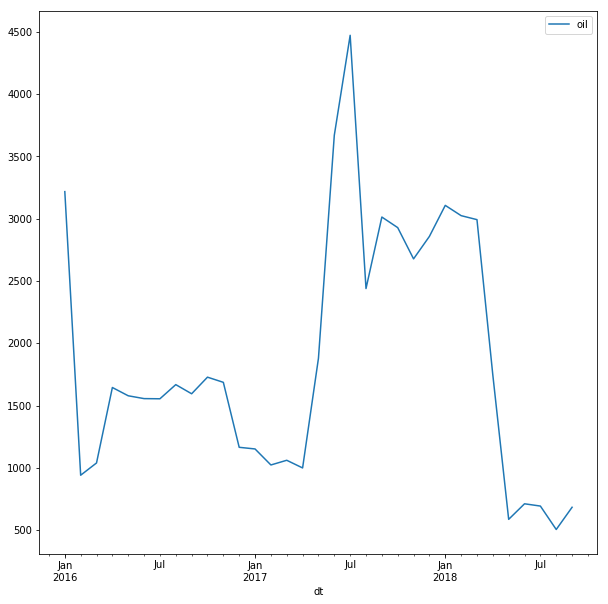

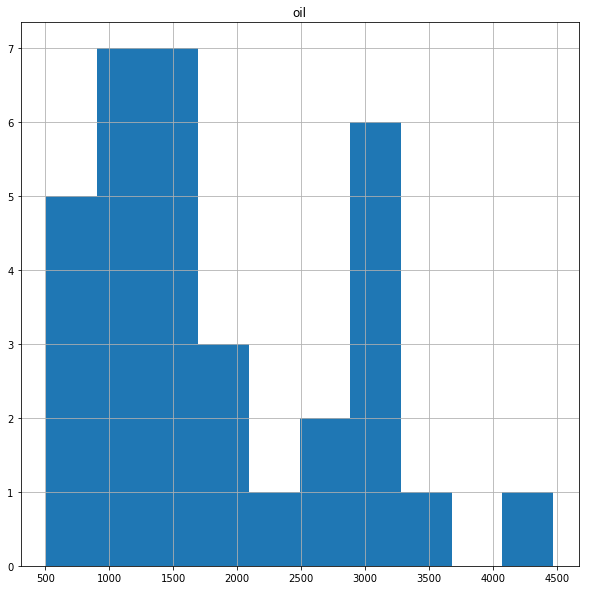

mean1=1475.524788, mean2=2234.741235
variance1=283058.867714, variance2=1407401.483474
Time Series may NOT be Stationary, since means and variances vary significantly.

Performing Augmented Dickey-Fuller Test to confirm stationarity...
ADF Statistic: -2.284942
p-value: 0.176870
Time Series is NOT Stationary, since p-value > 0.05


In [18]:
print ("Stationarity Check for %s" % chosen_well)
is_stationary = check_stationarity(well_df)

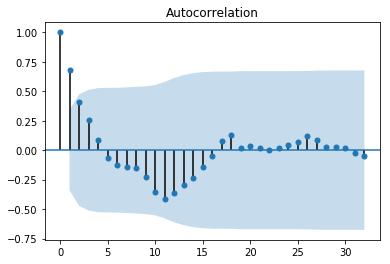

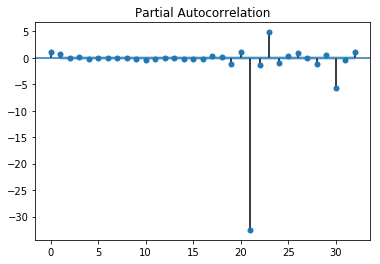

In [19]:
# ACF and PACF plots

plot_acf(well_df)
plot_pacf(well_df)
plt.show()

# setting d value for ARIMA model
if (is_stationary==True):
    d = 0
else:
    d = 1

In [20]:
p_range = q_range = list(range(0,3))  # taking values from 0 to 2

aic_values = []
bic_values = []
pq_values = []

for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(well_df, order=(p, d, q))
            results = model.fit(disp=-1)
            aic_values.append(ARMAResults.aic(results))
            bic_values.append(ARMAResults.bic(results))
            pq_values.append((p, q))
        except:
            pass

best_pq = pq_values[aic_values.index(min(aic_values))]  # (p,q) corresponding to lowest AIC score
print("(p,q) corresponding to lowest AIC score: ", best_pq)

(p,q) corresponding to lowest AIC score:  (0, 0)


In [21]:
# fitting an ARIMA model with chosen p, d, q values and calculating the mean squared error
from sklearn.metrics import mean_absolute_error

arima_model = ARIMA(well_df, order=(best_pq[0], 0, best_pq[1])).fit()
predictions = arima_model.predict(start=0, end=len(well_df)-1)

mse = mean_squared_error(list(well_df.oil), list(predictions))
print("Mean Squared Error:", mse)

mae = mean_absolute_error(list(well_df.oil), list(predictions))
print("Mean Absolute Error:", mae)

Mean Squared Error: 1006235.747983351
Mean Absolute Error: 841.4780975206611


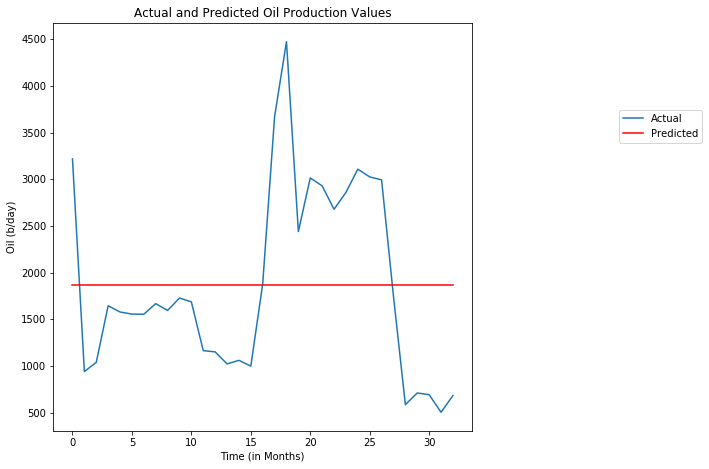

In [22]:
# comparing first 100 predictions with actual values

plt.figure(figsize=(7.5,7.5))
plt.plot(list(well_df.oil)[:100], label="Actual")
plt.plot(list(predictions)[:100], 'r', label="Predicted")

plt.xlabel("Time (in Months)")
plt.ylabel("Oil (b/day)")
plt.title("Actual and Predicted Oil Production Values")

plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8))
plt.show()

### OBJECTIVE 2: Top-10 Wells in the Brazil with Maximum Production of Oil

In [23]:
changes = []  # stores temperature change for cities
avg_2013 = []  # stores average of 2013 temperature for each city
avg_2023 = []  # stores average of 2023 temperature for each city

for each_well in set(salt_wells):
    new_well_df = df[df.well == each_well].drop("well", 1)  # new df for each city
    new_well_df_mean = new_well_df.resample("A").mean()  # stores yearly mean temperature values for city
    new_well_df_mean = new_well_df_mean.dropna()
    last_year_average = new_well_df_mean['oil'][-1]  # average of last year temperature for comparison later
    avg_2013.append(last_year_average)
    
    # making predictions for city for next 10 years
    p_range = q_range = [i for i in range(0,3)]  # taking values from 0 to 2

    aic_values = []
    bic_values = []
    pq_values = []

    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(new_well_df, order=(p, 0, q))
                results = model.fit(disp=-1)
                aic_values.append(ARMAResults.aic(results))
                bic_values.append(ARMAResults.bic(results))
                pq_values.append((p, q))
            except:
                pass
    
    best_pq = pq_values[aic_values.index(min(aic_values))]  # (p,q) corresponding to lowest AIC score
    
    arima_model = ARIMA(new_well_df, order=(best_pq[0], 0, best_pq[1])).fit()
    
    # make prediction for next 10 years using 120 steps
    out_of_sample_forecast = arima_model.forecast(steps=120)[0]
    average_after_10_years = np.mean(out_of_sample_forecast[-9:])  # average of 10th year's values (after 10 years) i.e. average of last 9 values (Jan-Sep because 2013 values end at September)
    avg_2023.append(average_after_10_years)
    
    changes.append(abs(last_year_average - average_after_10_years))
    
    top_10_changes_indices = sorted(range(len(changes)), key=lambda i: changes[i], reverse=True)[:10]
    top_10_well = [salt_wells[x] for x in top_10_changes_indices]
    top_10_well

In [24]:
top_10_well

['7baz4ess',
 '7bfr7ess',
 '7br69darjs',
 '7baz3ess',
 '7ll28drjs',
 '7sph7dsps',
 '7jub34hess',
 '9brsa908drjs',
 '7ll17drjs',
 '7jub58dpaess']

In [25]:
def create_folium_map(lat, lot, zfact):
    '''
    Cria um objeto Folium.Map do tipo OpenStreetMap centrado em (lat,lot) com nível de zoom zfact
    '''
    import folium
    tiles = 'http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}'
    attr = ('Tiles &copy; Esri &mdash; Sources: GEBCO, NOAA, CHS, OSU, UNH, CSUMB, National Geographic, DeLorme, NAVTEQ, and Esri')
    m = folium.Map(location=[lat,lot], 
            tiles=tiles,
            attr=attr,
            zoom_start=zfact)
    return m

In [26]:
m = create_folium_map(-22.0,-40.0,8)
m

In [27]:
def add_pocos_mapa(mapa, pocos, cor, kind=1, nome_grupo=u'default'):
    if kind != 1 and kind != 2:
        print("Erro: Tipo de marcação no mapa indisponível!")
        return False
    else:
        pocos_len = pocos.shape[0]
        grupo = folium.FeatureGroup(nome_grupo)
        for i in range(pocos_len):
            lat, lont = float(pocos['LATITUDE_BASE_DD'][i].replace(",",".")), float(pocos['LONGITUDE_BASE_DD'][i].replace(",","."))
            if kind==1:
                folium.Marker(
                    location=[lat, lont],
                    popup=pocos['POCO'][i],
                    icon=folium.Icon(color=cor),
                    ).add_to(grupo)
            if kind==2:
                folium.Circle(
                    location=[lat, lont],
                    popup=pocos['POCO'][i],
                    radius=15,
                    color='red',
                    fill=True,
                    fill_color='crimson'
                    ).add_to(grupo)
            grupo.add_to(mapa)

In [28]:
for index, row in pai.iterrows():
    poco_name = row['POCO'].lower().replace(' ', '').replace('-', '')
    if(poco_name not in top_10_well):
        pai.drop(index, inplace=True)

In [31]:
pai = pai.reset_index(drop=True)
pai

,POCO,TIPO,CATEGORIA,RECLASSIFICACAO,SITUACAO,LATITUDE_BASE_DD,LONGITUDE_BASE_DD,TESTE_DE_FORMACAO
0,7-SPH-7D-SPS,Explotatório,Desenvolvimento,PRODUTOR COMERCIAL DE PETRÓLEO,PRODUZINDO,"-25,6969480555","-43,1811002777",NaN
1,7-LL-17D-RJS,Explotatório,Desenvolvimento,PRODUTOR COMERCIAL DE PETRÓLEO,PRODUZINDO,"-25,3888480555","-42,7298591666",NaN
2,7-BAZ-4-ESS,Explotatório,Desenvolvimento,PRODUTOR COMERCIAL DE PETRÓLEO,PRODUZINDO,"-21,3200725","-40,0110583333",NaN
3,7-LL-28D-RJS,Explotatório,Desenvolvimento,PRODUTOR COMERCIAL DE PETRÓLEO,PRODUZINDO,"-25,4151638888","-42,7531302777",NaN
4,7-BAZ-3-ESS,Explotatório,Desenvolvimento,PRODUTOR COMERCIAL DE PETRÓLEO,PRODUZINDO,"-21,3349377777","-40,0179102777",NaN
5,7-JUB-58DPA-ESS,Explotatório,Desenvolvimento,PRODUTOR COMERCIAL DE PETRÓLEO,PRODUZINDO,"-21,2731608333","-40,0194652777",NaN
6,7-BR-69DA-RJS,Explotatório,Desenvolvimento,PRODUTOR COMERCIAL DE PETRÓLEO,PRODUZINDO,"-22,6143894444","-40,2374680555",NaN
7,7-BFR-7-ESS,Explotatório,Desenvolvimento,PRODUTOR COMERCIAL DE PETRÓLEO,PRODUZINDO,"-21,2236466666","-39,9699311111",NaN


In [32]:
add_pocos_mapa(
    m,
    pai,
    'red',
    nome_grupo="top 10"
)

In [33]:
m

## Conclusion

In this project, we:

<ul>
<li>Forecasted the temperature of a given city over a given period of time</li>
<li>Predicted the top-10 cities in the US which will experience the most temperature change from 2013-2013.</li>
<li>Analyzed the correlation between pollution levels and temperature, as well as the correlation between Greenhouse gas emissions and temperature, which helped us identify the Greenhouse Gas that has and will have the most impact on temperature change.</li>
</ul>